In [1]:
# https://www.youtube.com/watch?v=s3OUzmUDdg8

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
item1_embedding = np.array([1, 2, -3, 3])
item2_embedding = np.array([2, -3, -2, 4])

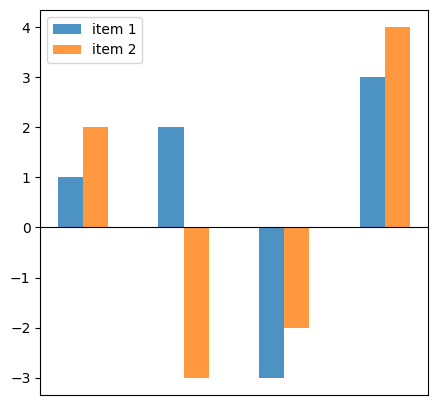

In [4]:
def plot_embeddings(emb1, emb2):
    plt.figure(figsize=(5, 5))
    plt.bar(np.arange(len(emb1)), emb1, width=0.25, alpha=0.8, label='item 1')
    plt.bar(np.arange(len(emb2)) + 0.25, emb2, width=0.25, alpha=0.8, label='item 2')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xticks(())
    plt.legend()
    plt.show()
plot_embeddings(item1_embedding, item2_embedding)

In [5]:
product = item1_embedding * item2_embedding
print(product)

[ 2 -6  6 12]


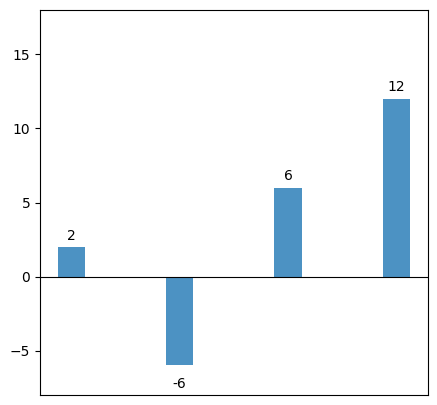

In [6]:
plt.figure(figsize=(5, 5))
plt.bar(np.arange(len(product)), product, width=0.25, alpha=0.8)
plt.axhline(0, color='black', linewidth=0.8)
# Add text labels above each bar
for i, v in enumerate(product):
    plt.text(i, v + 0.5 if v >= 0 else v - 1.5, v, ha='center')
plt.xticks(())
plt.ylim(-8, 18)
plt.show()

### Vectorization

In [7]:
item_embeddings = np.array([
    [1, 2, -3, 4],
    [2, -3, -2, 4],
    [-1, -2, 3, -4]
])

search_embeddings = np.array([
    [1, 2, -3, 4]
])

products = item_embeddings * search_embeddings
print(f'{item_embeddings.shape=} {search_embeddings.shape=} {products.shape=}')

item_embeddings.shape=(3, 4) search_embeddings.shape=(1, 4) products.shape=(3, 4)


In [8]:
products

array([[  1,   4,   9,  16],
       [  2,  -6,   6,  16],
       [ -1,  -4,  -9, -16]])

In [9]:
products.sum(axis=1, keepdims=True)

array([[ 30],
       [ 18],
       [-30]])

In [10]:
# we can use matmul to get the matrix product
np.matmul(item_embeddings, search_embeddings.T)    # .T transposes matrix

array([[ 30],
       [ 18],
       [-30]])

In [11]:
item_embeddings = np.array([
    [1, 2, -3, 4],
    [2, -3, -2, 4],
    [-1, -2, 3, -4]
])

search_embeddings = np.array([
    [1, 2, -3, 4],
    [-1, -2, 3, -4]
])

prod = np.matmul(item_embeddings, search_embeddings.T)
prod

array([[ 30, -30],
       [ 18, -18],
       [-30,  30]])

### Normalizing similarity

In [12]:
np.set_printoptions(suppress=True)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)   # exp(x)=e^x

attention_scores = softmax(prod)
attention_scores

array([[0.99999386, 0.        ],
       [0.00000614, 0.        ],
       [0.        , 1.        ]])

In [13]:
prod = np.array ([[1],
                  [-0.5],
                  [1.2]])
softmax(prod)

array([[0.4090761 ],
       [0.09127722],
       [0.49964668]])

In [14]:
prod = np.array ([[10],
                  [-5],
                  [12]])
softmax(prod)     # since numbers are big, over preference exits

array([[0.11920292],
       [0.00000004],
       [0.88079705]])

### Reducing Skew

Note: The skew is only bad when a network is initialized with random weights, the skew should be learned by fitting to the training data.

In [15]:
num_items = 4
num_queries = 1

embed_size = 1

item_embeddings = np.random.uniform(-1, 1, size=(num_items, embed_size))
search_embeddings = np.random.uniform(-1, 1, size=(num_queries, embed_size))
prod = np.matmul(item_embeddings, search_embeddings.T) / np.sqrt(embed_size)    # adding normalization
attention_scores = softmax(prod)
attention_scores

array([[0.25095801],
       [0.25243037],
       [0.24860256],
       [0.24800906]])

### Contextual Embeddings

Note: an "attention context" can be thought out as a weighted mean of the different key items.

Key embeddings are used for calculating attention scores/weights<br>
Value embeddings are used for the weighted mean<br><br>
Attention allows us to do contextual averaging of value embeddings

In [16]:
def attention_scores(key_embeddings, query_embeddings):
    return softmax(np.matmul(key_embeddings, query_embeddings.T) / np.sqrt(key_embeddings.shape[1]))

In [17]:
num_keys = 3
num_queries = 1

embed_size = 4

key_embeddings = np.random.uniform(-1, 1, size=(num_keys, embed_size))
query_embeddings = np.random.uniform(-1, 1, size=(num_queries, embed_size))
value_embeddings = np.random.uniform(-1, 1, size=(num_keys, embed_size))

attention_scores = attention_scores(key_embeddings, query_embeddings)
attention_scores

array([[0.35489092],
       [0.32221385],
       [0.32289523]])

### Context Embeddings

In [18]:
context_embeddings = np.matmul(attention_scores.T, value_embeddings)
context_embeddings

array([[-0.13030235, -0.5801874 , -0.36911158, -0.24800142]])

In [19]:
value_embeddings

array([[-0.5218319 , -0.72490943, -0.65903747, -0.3182499 ],
       [ 0.81982748, -0.11796767, -0.6387231 ,  0.1073417 ],
       [-0.648101  , -0.88236922,  0.21858565, -0.52538529]])

### Attention with Torch
Note: batch dimension is a way to parallely process multiple data samples at once

In [20]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [21]:
def calculate_attention(
    values: torch.Tensor,
    keys: torch.Tensor,
    query: torch.Tensor,
):
    # perform matmul
    attention_scores = torch.matmul(query, keys.transpose(-2, -1))

    # calculate attention
    attention_scores = attention_scores / math.sqrt(keys.shape[-1])
    attention_scores = F.softmax(attention_scores, dim=1)   # normalize
    attention = torch.matmul(attention_scores, values)
    return attention, attention_scores

In [24]:
batch_size = 2
num_queries = 4
num_keys = 16
embed_size = 8

query = torch.randn(batch_size, num_queries, embed_size)
keys = torch.randn(batch_size, num_keys, embed_size)
values = torch.randn(batch_size, num_keys, embed_size)

In [25]:
attention, attention_scores = calculate_attention(values, keys, query)

In [26]:
attention.shape, attention_scores.shape

(torch.Size([2, 4, 8]), torch.Size([2, 4, 16]))

In [50]:
text = "attention ! we will train attention ."
text_tokens = text.split()
vocab = set(text_tokens)
vocab_to_idx = {token: idx for idx, token in enumerate(vocab)}
print(vocab_to_idx)

{'train': 0, '!': 1, 'we': 2, 'attention': 3, '.': 4, 'will': 5}


In [51]:
int_tokens = torch.tensor([vocab_to_idx[token] for token in text_tokens])
int_tokens = int_tokens.unsqueeze(0)   # add dimension to vector (instead of size [7], size [1,7])
print(int_tokens, "\nshape:", int_tokens.shape)

tensor([[3, 1, 2, 5, 0, 3, 4]]) 
shape: torch.Size([1, 7])


In [52]:
embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=8)   #create embeddings given vocab and dimension

In [53]:
embedding_layer.weight

Parameter containing:
tensor([[-1.9212, -0.3754,  1.3592,  0.5905, -1.3943, -1.1740,  0.5535,  0.7490],
        [-0.1627,  1.8073, -1.1398,  0.2125,  1.2963, -0.3229,  0.1107,  0.4007],
        [ 0.1364,  0.7996, -0.0675, -0.8208,  0.8766, -0.2193, -0.8482,  0.9698],
        [-0.2813, -0.4880, -2.2235,  0.5737, -1.7065,  2.3495,  1.9557, -0.5051],
        [ 0.0134, -0.8820, -1.1370, -0.8105,  1.8266,  0.4660, -0.1464, -0.2607],
        [ 0.3822,  1.7236, -0.8083,  1.2254, -0.5015,  0.8880,  0.4678,  0.0830]],
       requires_grad=True)

In [54]:
embeddings = embedding_layer(int_tokens)   # get embeddings 
embeddings

tensor([[[-0.2813, -0.4880, -2.2235,  0.5737, -1.7065,  2.3495,  1.9557,
          -0.5051],
         [-0.1627,  1.8073, -1.1398,  0.2125,  1.2963, -0.3229,  0.1107,
           0.4007],
         [ 0.1364,  0.7996, -0.0675, -0.8208,  0.8766, -0.2193, -0.8482,
           0.9698],
         [ 0.3822,  1.7236, -0.8083,  1.2254, -0.5015,  0.8880,  0.4678,
           0.0830],
         [-1.9212, -0.3754,  1.3592,  0.5905, -1.3943, -1.1740,  0.5535,
           0.7490],
         [-0.2813, -0.4880, -2.2235,  0.5737, -1.7065,  2.3495,  1.9557,
          -0.5051],
         [ 0.0134, -0.8820, -1.1370, -0.8105,  1.8266,  0.4660, -0.1464,
          -0.2607]]], grad_fn=<EmbeddingBackward0>)

In [66]:
embedding_dim = embeddings.shape[2]

In [67]:
query_dense_layer = nn.Linear(in_features=embedding_dim, out_features=8)
key_dense_layer = nn.Linear(in_features=embedding_dim, out_features=8)
value_dense_layer = nn.Linear(in_features=embedding_dim, out_features=8)

In [68]:
query = query_dense_layer(embeddings)
key = key_dense_layer(embeddings)
value = value_dense_layer(embeddings)

query.shape, key.shape, value.shape

(torch.Size([1, 7, 8]), torch.Size([1, 7, 8]), torch.Size([1, 7, 8]))

In [70]:
attention, attention_scores = calculate_attention(value, key, query)
attention.shape, attention_scores.shape

(torch.Size([1, 7, 8]), torch.Size([1, 7, 7]))

In [71]:
attention_scores

tensor([[[0.1675, 0.1664, 0.1575, 0.1527, 0.1121, 0.1675, 0.1946],
         [0.1473, 0.1378, 0.1493, 0.1357, 0.1602, 0.1473, 0.1138],
         [0.1169, 0.1286, 0.1292, 0.1236, 0.1188, 0.1169, 0.1174],
         [0.1423, 0.1757, 0.1490, 0.1811, 0.1369, 0.1423, 0.1036],
         [0.1379, 0.1065, 0.1251, 0.1425, 0.2748, 0.1379, 0.0802],
         [0.1675, 0.1664, 0.1575, 0.1527, 0.1121, 0.1675, 0.1946],
         [0.1205, 0.1186, 0.1323, 0.1116, 0.0851, 0.1205, 0.1959]]],
       grad_fn=<SoftmaxBackward0>)

Attention masks allow us to fix the problem of looking at every word all at once, we need to only be looking backward when generating

In [73]:
right_triangular_mask = torch.tril(torch.ones_like(attention_scores))
right_triangular_mask

tensor([[[1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1.]]])

In [77]:
def calculate_masked_attention(
    values: torch.Tensor,
    keys: torch.Tensor,
    query: torch.Tensor,
    mask: torch.Tensor = None,
):
    # perform matmul
    attention_scores = torch.matmul(query, keys.transpose(-2, -1))
    if mask is not None:
        attention_scores = torch.where(mask == 0, torch.tensor(-1e9), attention_scores)
    
    # calculate attention
    attention_scores = attention_scores / math.sqrt(keys.shape[-1])
    attention_scores = F.softmax(attention_scores, dim=1)   # normalize
    attention = torch.matmul(attention_scores, values)
    return attention, attention_scores

In [78]:
attention_context, attention_scores = calculate_masked_attention(value, key, query, right_triangular_mask)

In [79]:
attention_context.shape

torch.Size([1, 7, 8])

In [80]:
attention_scores

tensor([[[0.1675, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1473, 0.1653, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1169, 0.1543, 0.1864, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1423, 0.2108, 0.2150, 0.3080, 0.0000, 0.0000, 0.0000],
         [0.1379, 0.1277, 0.1804, 0.2424, 0.5821, 0.0000, 0.0000],
         [0.1675, 0.1996, 0.2272, 0.2598, 0.2375, 0.5816, 0.0000],
         [0.1205, 0.1423, 0.1909, 0.1898, 0.1803, 0.4184, 1.0000]]],
       grad_fn=<SoftmaxBackward0>)

### Transformer Decoder